## imports

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nibabel as nib
import os
import sys
from os import listdir
from os.path import isfile, join, exists
from scipy.spatial.distance import pdist, squareform, cosine, euclidean, mahalanobis
from statsmodels.stats.multitest import multipletests
import scipy.io as sio
import scipy.stats as stats
from PIL import Image
from IPython.core.debugger import set_trace
import scipy.io as sio
import torchvision.datasets as datasets
from tqdm import tqdm
import time
import importlib

sys.path.append('/home/jacobpri/git/RotspaceIT/')

from RotspaceIT import rsatools as rsa
from RotspaceIT import nethook as nethook
from RotspaceIT import nnutils as utils
from RotspaceIT import floc_selectivity

importlib.reload(rsa)
importlib.reload(utils)
importlib.reload(floc_selectivity)

<module 'RotspaceIT.floc_selectivity' from '/home/jacobpri/git/RotspaceIT/RotspaceIT/floc_selectivity.py'>

In [34]:
## hyperparameters
arch = 'alexnet'
trained_on = 'object'
imageset = 'imagefiles-fullset'
img_dim = 224
batch_size = 80
FDR_p = 0.05
save_as = '.npy'
overwrite = False
verbose = True
draw_plots = True

In [35]:
## directory management

home_dir = '/home/jacobpri/git/RotspaceIT/'
data_dir = '/user_data/jacobpri/Project/RotspaceIT/'

# target directory for loading activations
activation_loaddir = join(data_dir,'data','d02_modeling','activations')

# target directory for saving layer-wise pref dicts
prefdict_savedir = join(data_dir,'data','d02_modeling','selectivity')

# folder of image sets
imageset_dir = join(home_dir,'imagesets')

load_arch = arch + '-' + trained_on

dirs = os.listdir(imageset_dir)

found = False
for d in dirs:
    d_ = os.listdir(join(imageset_dir,d))
    if (imageset in d_):
        imageset_dir = join(imageset_dir, d, imageset)
        activation_loaddir = join(activation_loaddir, load_arch, d, imageset, 'dim' + str(img_dim))
        prefdict_savedir = join(prefdict_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        found = True
        break

if found is False:
    raise ValueError('image set not found')   

# create savedir if it doesn't yet exist 
os.makedirs(prefdict_savedir, exist_ok=True)

print("imageset dir %s\n" % imageset_dir)
print("activation load destination: %s\n" % activation_loaddir)
print("prefdict save destination: %s\n" % prefdict_savedir)

assert(exists(activation_loaddir))
assert(exists(imageset_dir))
assert(exists(prefdict_savedir))
assert(save_as == '.npy' or save_as == '.mat')

imageset dir /home/jacobpri/git/RotspaceIT/imagesets/localizer/imagefiles-fullset

activation load destination: /user_data/jacobpri/Project/RotspaceIT/data/d02_modeling/activations/alexnet-object/localizer/imagefiles-fullset/dim224

prefdict save destination: /user_data/jacobpri/Project/RotspaceIT/data/d02_modeling/selectivity/alexnet-object/localizer/imagefiles-fullset/dim224



In [36]:
layer_names_fn = join(activation_loaddir, 'lay_names_user_fmt_batchsize-' + str(batch_size) + '.npy')
assert(exists(layer_names_fn))

layer_names = np.load(layer_names_fn)

all_types = ['conv','relu','pool','norm','drop','fc','downsample','identity','flatten']
includes = all_types #['conv','fc','relu']#all_types#['relu','conv','fc']#all_types#['conv','fc','relu']#all_types#['conv','relu','fc','relu','norm','drop','pool','flatten']#all_types#['conv','fc']

layers_to_load = []

for i in range(len(layer_names)):
    if any(s in layer_names[i] for s in includes):
        layers_to_load.append(layer_names[i])

print(layers_to_load,'\n')
print('%d layers chosen' % len(layers_to_load))

['1_conv1', '2_relu1', '3_maxpool1', '4_conv2', '5_relu2', '6_maxpool2', '7_conv3', '8_relu3', '9_conv4', '10_relu4', '11_conv5', '12_relu5', '13_maxpool5', '14_avgpool5', '15_drop5', '16_fc6', '17_relu6', '18_drop6', '19_fc7', '20_relu7', '21_fc8'] 

21 layers chosen


In [39]:
utils.load_batched_activations('/user_data/jacobpri/Project/RotspaceIT/data/d02_modeling/activations/alexnet-object/localizer/imagefiles-fullset/dim224',
                              ['21_fc8'],80)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jacobpri/git/RotspaceIT/data/d02_modeling/activations/alexnet-object/localizer/imagefiles-fullset/dim224/21_fc8_batchsize-80_batch-0.npy'

In [37]:
## load batched activations, reshape to 2d, concatenate

# test on a single layer
Y = utils.load_batched_activations(activation_loaddir, ['21_fc8'], batch_size)

if draw_plots is True:
    rsa.plot_matrix(Y,tl = 'example layer',fontsize=16)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jacobpri/git/RotspaceIT/data/d02_modeling/activations/alexnet-object/localizer/imagefiles-fullset/dim224/21_fc8_batchsize-80_batch-0.npy'

In [38]:
print(activation_loaddir)

/user_data/jacobpri/Project/RotspaceIT/data/d02_modeling/activations/alexnet-object/localizer/imagefiles-fullset/dim224


In [31]:
## organize category indices

dataset = datasets.ImageFolder(root = imageset_dir)

# print some info -> verify correct # imgs, etc
categ_idx = np.array(dataset.targets)

if imageset == 'vpnl-floc':
    floc_categs = np.array(['adult','body','car','child','corridor','house','instrument','limb','number','scrambled','word'])
    floc_domains = np.array(['faces','bodies','objects','scenes','characters','scrambled'])
    floc_categ_domain_ref = np.array([0,1,2,0,3,3,2,1,4,5,4])
    categ_nimg = 144

    categ_idx = np.repeat(floc_categ_domain_ref,categ_nimg)
else:
    floc_domains = dataset.classes
    
print(floc_domains)

['Bodies', 'Faces', 'Objects', 'Scenes', 'Scrambled']


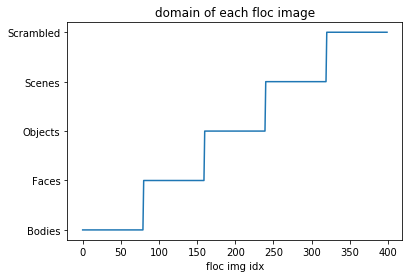

In [10]:
if draw_plots is True:
    ## visualize, for sanity
    plt.figure()
    plt.plot(categ_idx)
    plt.yticks(np.arange(len(floc_domains)),floc_domains);
    plt.xlabel('floc img idx')
    plt.title('domain of each floc image');

Conducting deepnet floc experiments:   0%|          | 0/100 [00:00<?, ?it/s]

1_conv1
size of initial region is 12462 units. comparison is 0 vs. 1
new size of region is 2 units. comparison is 0 vs. 2
new size of region is 0 units. comparison is 0 vs. 3
new size of region is 0 units. comparison is 0 vs. 4
size of initial region is 24542 units. comparison is 1 vs. 0
new size of region is 19538 units. comparison is 1 vs. 2
new size of region is 7693 units. comparison is 1 vs. 3
new size of region is 7180 units. comparison is 1 vs. 4
size of initial region is 329 units. comparison is 2 vs. 0
new size of region is 309 units. comparison is 2 vs. 1
new size of region is 306 units. comparison is 2 vs. 3
new size of region is 141 units. comparison is 2 vs. 4
size of initial region is 37751 units. comparison is 3 vs. 0
new size of region is 23291 units. comparison is 3 vs. 1
new size of region is 21720 units. comparison is 3 vs. 2
new size of region is 20235 units. comparison is 3 vs. 4
size of initial region is 3230 units. comparison is 4 vs. 0
new size of region is 2867

Conducting deepnet floc experiments:   4%|▎         | 3.7037037037037037/100 [00:13<05:49,  3.63s/it]

2_norm1
size of initial region is 24215 units. comparison is 0 vs. 1
new size of region is 325 units. comparison is 0 vs. 2
new size of region is 2 units. comparison is 0 vs. 3
new size of region is 0 units. comparison is 0 vs. 4
size of initial region is 17383 units. comparison is 1 vs. 0
new size of region is 13760 units. comparison is 1 vs. 2
new size of region is 9683 units. comparison is 1 vs. 3
new size of region is 9188 units. comparison is 1 vs. 4
size of initial region is 1471 units. comparison is 2 vs. 0
new size of region is 1175 units. comparison is 2 vs. 1
new size of region is 983 units. comparison is 2 vs. 3
new size of region is 747 units. comparison is 2 vs. 4
size of initial region is 12893 units. comparison is 3 vs. 0
new size of region is 8719 units. comparison is 3 vs. 1
new size of region is 7852 units. comparison is 3 vs. 2
new size of region is 6625 units. comparison is 3 vs. 4
size of initial region is 3708 units. comparison is 4 vs. 0
new size of region is 284

Conducting deepnet floc experiments:   7%|▋         | 7.407407407407407/100 [00:26<05:35,  3.62s/it] 

3_relu1


/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


size of initial region is 17876 units. comparison is 0 vs. 1
new size of region is 40 units. comparison is 0 vs. 2
new size of region is 4 units. comparison is 0 vs. 3
new size of region is 4 units. comparison is 0 vs. 4
size of initial region is 16871 units. comparison is 1 vs. 0
new size of region is 12439 units. comparison is 1 vs. 2
new size of region is 8774 units. comparison is 1 vs. 3
new size of region is 8360 units. comparison is 1 vs. 4
size of initial region is 1796 units. comparison is 2 vs. 0
new size of region is 1153 units. comparison is 2 vs. 1
new size of region is 932 units. comparison is 2 vs. 3
new size of region is 783 units. comparison is 2 vs. 4
size of initial region is 13984 units. comparison is 3 vs. 0
new size of region is 7825 units. comparison is 3 vs. 1
new size of region is 5439 units. comparison is 3 vs. 2
new size of region is 3586 units. comparison is 3 vs. 4
size of initial region is 7357 units. comparison is 4 vs. 0
new size of region is 5435 units. 

Conducting deepnet floc experiments:  11%|█         | 11.11111111111111/100 [00:40<05:22,  3.63s/it]

4_maxpool1
size of initial region is 6566 units. comparison is 0 vs. 1
new size of region is 19 units. comparison is 0 vs. 2
new size of region is 0 units. comparison is 0 vs. 3
new size of region is 0 units. comparison is 0 vs. 4
size of initial region is 8110 units. comparison is 1 vs. 0
new size of region is 5457 units. comparison is 1 vs. 2
new size of region is 3380 units. comparison is 1 vs. 3
new size of region is 2975 units. comparison is 1 vs. 4
size of initial region is 434 units. comparison is 2 vs. 0
new size of region is 255 units. comparison is 2 vs. 1
new size of region is 176 units. comparison is 2 vs. 3
new size of region is 164 units. comparison is 2 vs. 4
size of initial region is 18962 units. comparison is 3 vs. 0
new size of region is 12481 units. comparison is 3 vs. 1
new size of region is 8090 units. comparison is 3 vs. 2
new size of region is 2998 units. comparison is 3 vs. 4
size of initial region is 9014 units. comparison is 4 vs. 0
new size of region is 6128 

Conducting deepnet floc experiments:  15%|█▍        | 14.814814814814815/100 [00:43<03:57,  2.79s/it]

5_conv2
size of initial region is 20745 units. comparison is 0 vs. 1
new size of region is 140 units. comparison is 0 vs. 2
new size of region is 33 units. comparison is 0 vs. 3
new size of region is 27 units. comparison is 0 vs. 4
size of initial region is 24388 units. comparison is 1 vs. 0
new size of region is 16778 units. comparison is 1 vs. 2
new size of region is 12104 units. comparison is 1 vs. 3
new size of region is 10995 units. comparison is 1 vs. 4
size of initial region is 1622 units. comparison is 2 vs. 0
new size of region is 1247 units. comparison is 2 vs. 1
new size of region is 989 units. comparison is 2 vs. 3
new size of region is 834 units. comparison is 2 vs. 4
size of initial region is 20830 units. comparison is 3 vs. 0
new size of region is 13781 units. comparison is 3 vs. 1
new size of region is 10750 units. comparison is 3 vs. 2
new size of region is 4523 units. comparison is 3 vs. 4
size of initial region is 16613 units. comparison is 4 vs. 0
new size of region

Conducting deepnet floc experiments:  19%|█▊        | 18.51851851851852/100 [00:52<03:37,  2.67s/it] 

6_norm2
size of initial region is 21490 units. comparison is 0 vs. 1
new size of region is 130 units. comparison is 0 vs. 2
new size of region is 21 units. comparison is 0 vs. 3
new size of region is 18 units. comparison is 0 vs. 4
size of initial region is 25133 units. comparison is 1 vs. 0
new size of region is 17346 units. comparison is 1 vs. 2
new size of region is 12502 units. comparison is 1 vs. 3
new size of region is 10932 units. comparison is 1 vs. 4
size of initial region is 1636 units. comparison is 2 vs. 0
new size of region is 1260 units. comparison is 2 vs. 1
new size of region is 948 units. comparison is 2 vs. 3
new size of region is 753 units. comparison is 2 vs. 4
size of initial region is 20456 units. comparison is 3 vs. 0
new size of region is 13203 units. comparison is 3 vs. 1
new size of region is 9722 units. comparison is 3 vs. 2
new size of region is 3819 units. comparison is 3 vs. 4
size of initial region is 18701 units. comparison is 4 vs. 0
new size of region 

Conducting deepnet floc experiments:  22%|██▏       | 22.22222222222222/100 [01:01<03:20,  2.58s/it]

7_relu2
size of initial region is 18561 units. comparison is 0 vs. 1
new size of region is 84 units. comparison is 0 vs. 2
new size of region is 52 units. comparison is 0 vs. 3
new size of region is 45 units. comparison is 0 vs. 4
size of initial region is 13673 units. comparison is 1 vs. 0
new size of region is 9479 units. comparison is 1 vs. 2
new size of region is 6716 units. comparison is 1 vs. 3
new size of region is 5943 units. comparison is 1 vs. 4
size of initial region is 688 units. comparison is 2 vs. 0
new size of region is 511 units. comparison is 2 vs. 1
new size of region is 419 units. comparison is 2 vs. 3
new size of region is 358 units. comparison is 2 vs. 4
size of initial region is 12429 units. comparison is 3 vs. 0
new size of region is 8227 units. comparison is 3 vs. 1
new size of region is 5571 units. comparison is 3 vs. 2
new size of region is 2209 units. comparison is 3 vs. 4
size of initial region is 11966 units. comparison is 4 vs. 0
new size of region is 8060

Conducting deepnet floc experiments:  26%|██▌       | 25.925925925925924/100 [01:09<03:06,  2.51s/it]

8_maxpool2
size of initial region is 8893 units. comparison is 0 vs. 1
new size of region is 205 units. comparison is 0 vs. 2
new size of region is 125 units. comparison is 0 vs. 3
new size of region is 77 units. comparison is 0 vs. 4
size of initial region is 5692 units. comparison is 1 vs. 0
new size of region is 4121 units. comparison is 1 vs. 2
new size of region is 3221 units. comparison is 1 vs. 3
new size of region is 2655 units. comparison is 1 vs. 4
size of initial region is 303 units. comparison is 2 vs. 0
new size of region is 160 units. comparison is 2 vs. 1
new size of region is 107 units. comparison is 2 vs. 3
new size of region is 88 units. comparison is 2 vs. 4
size of initial region is 4596 units. comparison is 3 vs. 0
new size of region is 3104 units. comparison is 3 vs. 1
new size of region is 2163 units. comparison is 3 vs. 2
new size of region is 670 units. comparison is 3 vs. 4
size of initial region is 7217 units. comparison is 4 vs. 0
new size of region is 4975 

Conducting deepnet floc experiments:  30%|██▉       | 29.629629629629626/100 [01:11<02:14,  1.91s/it]

new size of region is 3448 units. comparison is 4 vs. 2
new size of region is 1629 units. comparison is 4 vs. 3
9_conv3
size of initial region is 11561 units. comparison is 0 vs. 1
new size of region is 379 units. comparison is 0 vs. 2
new size of region is 177 units. comparison is 0 vs. 3
new size of region is 127 units. comparison is 0 vs. 4
size of initial region is 14758 units. comparison is 1 vs. 0
new size of region is 10612 units. comparison is 1 vs. 2
new size of region is 7605 units. comparison is 1 vs. 3
new size of region is 6965 units. comparison is 1 vs. 4
size of initial region is 1600 units. comparison is 2 vs. 0
new size of region is 948 units. comparison is 2 vs. 1
new size of region is 545 units. comparison is 2 vs. 3
new size of region is 455 units. comparison is 2 vs. 4
size of initial region is 12846 units. comparison is 3 vs. 0
new size of region is 7048 units. comparison is 3 vs. 1
new size of region is 4941 units. comparison is 3 vs. 2
new size of region is 2328

Conducting deepnet floc experiments:  33%|███▎      | 33.33333333333333/100 [01:14<01:44,  1.57s/it] 

new size of region is 5448 units. comparison is 4 vs. 2
new size of region is 2633 units. comparison is 4 vs. 3
10_norm3
size of initial region is 13304 units. comparison is 0 vs. 1
new size of region is 399 units. comparison is 0 vs. 2
new size of region is 174 units. comparison is 0 vs. 3
new size of region is 124 units. comparison is 0 vs. 4
size of initial region is 13382 units. comparison is 1 vs. 0
new size of region is 9541 units. comparison is 1 vs. 2
new size of region is 7081 units. comparison is 1 vs. 3
new size of region is 6351 units. comparison is 1 vs. 4
size of initial region is 1554 units. comparison is 2 vs. 0
new size of region is 932 units. comparison is 2 vs. 1
new size of region is 548 units. comparison is 2 vs. 3
new size of region is 457 units. comparison is 2 vs. 4
size of initial region is 10101 units. comparison is 3 vs. 0
new size of region is 5940 units. comparison is 3 vs. 1
new size of region is 4178 units. comparison is 3 vs. 2
new size of region is 1626

Conducting deepnet floc experiments:  37%|███▋      | 37.03703703703703/100 [01:17<01:23,  1.33s/it]

new size of region is 6346 units. comparison is 4 vs. 2
new size of region is 3020 units. comparison is 4 vs. 3
11_relu3
size of initial region is 11396 units. comparison is 0 vs. 1
new size of region is 220 units. comparison is 0 vs. 2
new size of region is 100 units. comparison is 0 vs. 3
new size of region is 76 units. comparison is 0 vs. 4
size of initial region is 9191 units. comparison is 1 vs. 0
new size of region is 6312 units. comparison is 1 vs. 2
new size of region is 4723 units. comparison is 1 vs. 3
new size of region is 4348 units. comparison is 1 vs. 4
size of initial region is 719 units. comparison is 2 vs. 0
new size of region is 357 units. comparison is 2 vs. 1
new size of region is 232 units. comparison is 2 vs. 3
new size of region is 180 units. comparison is 2 vs. 4
size of initial region is 6814 units. comparison is 3 vs. 0
new size of region is 4460 units. comparison is 3 vs. 1
new size of region is 3139 units. comparison is 3 vs. 2
new size of region is 1132 uni

Conducting deepnet floc experiments:  41%|████      | 40.74074074074073/100 [01:20<01:08,  1.16s/it]

new size of region is 4239 units. comparison is 4 vs. 2
new size of region is 1868 units. comparison is 4 vs. 3
12_conv4
size of initial region is 15616 units. comparison is 0 vs. 1
new size of region is 2629 units. comparison is 0 vs. 2
new size of region is 811 units. comparison is 0 vs. 3
new size of region is 474 units. comparison is 0 vs. 4
size of initial region is 15174 units. comparison is 1 vs. 0
new size of region is 11877 units. comparison is 1 vs. 2
new size of region is 9067 units. comparison is 1 vs. 3
new size of region is 7926 units. comparison is 1 vs. 4
size of initial region is 2536 units. comparison is 2 vs. 0
new size of region is 1286 units. comparison is 2 vs. 1
new size of region is 861 units. comparison is 2 vs. 3
new size of region is 721 units. comparison is 2 vs. 4
size of initial region is 10731 units. comparison is 3 vs. 0
new size of region is 6366 units. comparison is 3 vs. 1
new size of region is 5181 units. comparison is 3 vs. 2
new size of region is 1

Conducting deepnet floc experiments:  44%|████▍     | 44.444444444444436/100 [01:23<00:58,  1.05s/it]

new size of region is 9188 units. comparison is 4 vs. 2
new size of region is 4504 units. comparison is 4 vs. 3
13_norm4
size of initial region is 15422 units. comparison is 0 vs. 1
new size of region is 1465 units. comparison is 0 vs. 2
new size of region is 450 units. comparison is 0 vs. 3
new size of region is 254 units. comparison is 0 vs. 4
size of initial region is 14874 units. comparison is 1 vs. 0
new size of region is 10586 units. comparison is 1 vs. 2
new size of region is 8307 units. comparison is 1 vs. 3
new size of region is 7304 units. comparison is 1 vs. 4
size of initial region is 3436 units. comparison is 2 vs. 0
new size of region is 1695 units. comparison is 2 vs. 1
new size of region is 1063 units. comparison is 2 vs. 3
new size of region is 901 units. comparison is 2 vs. 4
size of initial region is 10544 units. comparison is 3 vs. 0
new size of region is 6337 units. comparison is 3 vs. 1
new size of region is 4640 units. comparison is 3 vs. 2
new size of region is 

Conducting deepnet floc experiments:  48%|████▊     | 48.14814814814814/100 [01:26<00:50,  1.03it/s] 

new size of region is 7652 units. comparison is 4 vs. 2
new size of region is 3770 units. comparison is 4 vs. 3
14_relu4
size of initial region is 10281 units. comparison is 0 vs. 1
new size of region is 715 units. comparison is 0 vs. 2
new size of region is 194 units. comparison is 0 vs. 3
new size of region is 100 units. comparison is 0 vs. 4
size of initial region is 10328 units. comparison is 1 vs. 0
new size of region is 7037 units. comparison is 1 vs. 2
new size of region is 5465 units. comparison is 1 vs. 3
new size of region is 4910 units. comparison is 1 vs. 4
size of initial region is 2033 units. comparison is 2 vs. 0
new size of region is 930 units. comparison is 2 vs. 1
new size of region is 556 units. comparison is 2 vs. 3
new size of region is 482 units. comparison is 2 vs. 4
size of initial region is 7962 units. comparison is 3 vs. 0
new size of region is 5092 units. comparison is 3 vs. 1
new size of region is 3604 units. comparison is 3 vs. 2
new size of region is 1473 

Conducting deepnet floc experiments:  52%|█████▏    | 51.85185185185184/100 [01:28<00:43,  1.10it/s]

new size of region is 5162 units. comparison is 4 vs. 2
new size of region is 2298 units. comparison is 4 vs. 3
15_conv5
size of initial region is 13944 units. comparison is 0 vs. 1
new size of region is 4888 units. comparison is 0 vs. 2
new size of region is 1802 units. comparison is 0 vs. 3
new size of region is 1235 units. comparison is 0 vs. 4
size of initial region is 9019 units. comparison is 1 vs. 0
new size of region is 7271 units. comparison is 1 vs. 2
new size of region is 5260 units. comparison is 1 vs. 3
new size of region is 4660 units. comparison is 1 vs. 4
size of initial region is 2431 units. comparison is 2 vs. 0
new size of region is 1265 units. comparison is 2 vs. 1
new size of region is 830 units. comparison is 2 vs. 3
new size of region is 744 units. comparison is 2 vs. 4
size of initial region is 8734 units. comparison is 3 vs. 0
new size of region is 6133 units. comparison is 3 vs. 1
new size of region is 5173 units. comparison is 3 vs. 2
new size of region is 15

Conducting deepnet floc experiments:  56%|█████▌    | 55.55555555555554/100 [01:30<00:35,  1.25it/s]

new size of region is 8326 units. comparison is 4 vs. 1
new size of region is 7462 units. comparison is 4 vs. 2
new size of region is 3436 units. comparison is 4 vs. 3
16_norm5
size of initial region is 11053 units. comparison is 0 vs. 1
new size of region is 2057 units. comparison is 0 vs. 2
new size of region is 745 units. comparison is 0 vs. 3
new size of region is 463 units. comparison is 0 vs. 4
size of initial region is 11474 units. comparison is 1 vs. 0
new size of region is 8209 units. comparison is 1 vs. 2
new size of region is 6166 units. comparison is 1 vs. 3
new size of region is 5486 units. comparison is 1 vs. 4
size of initial region is 4278 units. comparison is 2 vs. 0
new size of region is 1857 units. comparison is 2 vs. 1
new size of region is 931 units. comparison is 2 vs. 3
new size of region is 803 units. comparison is 2 vs. 4
size of initial region is 9172 units. comparison is 3 vs. 0
new size of region is 5553 units. comparison is 3 vs. 1
new size of region is 372

Conducting deepnet floc experiments:  59%|█████▉    | 59.259259259259245/100 [01:32<00:29,  1.40it/s]

new size of region is 7734 units. comparison is 4 vs. 1
new size of region is 6154 units. comparison is 4 vs. 2
new size of region is 2752 units. comparison is 4 vs. 3
17_relu5
size of initial region is 6737 units. comparison is 0 vs. 1
new size of region is 868 units. comparison is 0 vs. 2
new size of region is 350 units. comparison is 0 vs. 3
new size of region is 240 units. comparison is 0 vs. 4
size of initial region is 8332 units. comparison is 1 vs. 0
new size of region is 5810 units. comparison is 1 vs. 2
new size of region is 4325 units. comparison is 1 vs. 3
new size of region is 3899 units. comparison is 1 vs. 4
size of initial region is 2276 units. comparison is 2 vs. 0
new size of region is 801 units. comparison is 2 vs. 1
new size of region is 337 units. comparison is 2 vs. 3
new size of region is 296 units. comparison is 2 vs. 4
size of initial region is 7148 units. comparison is 3 vs. 0
new size of region is 4436 units. comparison is 3 vs. 1
new size of region is 2880 un

Conducting deepnet floc experiments:  63%|██████▎   | 62.96296296296295/100 [01:34<00:24,  1.54it/s] 

new size of region is 1802 units. comparison is 4 vs. 3
18_maxpool5
size of initial region is 1801 units. comparison is 0 vs. 1
new size of region is 259 units. comparison is 0 vs. 2
new size of region is 139 units. comparison is 0 vs. 3
new size of region is 119 units. comparison is 0 vs. 4
size of initial region is 2231 units. comparison is 1 vs. 0
new size of region is 1509 units. comparison is 1 vs. 2
new size of region is 1224 units. comparison is 1 vs. 3
new size of region is 1129 units. comparison is 1 vs. 4
size of initial region is 922 units. comparison is 2 vs. 0
new size of region is 346 units. comparison is 2 vs. 1
new size of region is 131 units. comparison is 2 vs. 3
new size of region is 117 units. comparison is 2 vs. 4
size of initial region is 2010 units. comparison is 3 vs. 0
new size of region is 1279 units. comparison is 3 vs. 1


Conducting deepnet floc experiments:  67%|██████▋   | 66.66666666666666/100 [01:35<00:16,  1.99it/s]

new size of region is 796 units. comparison is 3 vs. 2
new size of region is 361 units. comparison is 3 vs. 4
size of initial region is 1617 units. comparison is 4 vs. 0
new size of region is 1124 units. comparison is 4 vs. 1
new size of region is 802 units. comparison is 4 vs. 2
new size of region is 314 units. comparison is 4 vs. 3
19_avgpool5
size of initial region is 1801 units. comparison is 0 vs. 1
new size of region is 259 units. comparison is 0 vs. 2
new size of region is 139 units. comparison is 0 vs. 3
new size of region is 119 units. comparison is 0 vs. 4
size of initial region is 2231 units. comparison is 1 vs. 0
new size of region is 1509 units. comparison is 1 vs. 2
new size of region is 1224 units. comparison is 1 vs. 3
new size of region is 1129 units. comparison is 1 vs. 4
size of initial region is 922 units. comparison is 2 vs. 0
new size of region is 346 units. comparison is 2 vs. 1
new size of region is 131 units. comparison is 2 vs. 3
new size of region is 117 unit

Conducting deepnet floc experiments:  70%|███████   | 70.37037037037037/100 [01:35<00:11,  2.57it/s]

new size of region is 796 units. comparison is 3 vs. 2
new size of region is 361 units. comparison is 3 vs. 4
size of initial region is 1617 units. comparison is 4 vs. 0
new size of region is 1124 units. comparison is 4 vs. 1
new size of region is 802 units. comparison is 4 vs. 2
new size of region is 314 units. comparison is 4 vs. 3
20_fc6


Conducting deepnet floc experiments:  74%|███████▍  | 74.07407407407408/100 [01:36<00:07,  3.38it/s]

size of initial region is 1576 units. comparison is 0 vs. 1
new size of region is 569 units. comparison is 0 vs. 2
new size of region is 323 units. comparison is 0 vs. 3
new size of region is 240 units. comparison is 0 vs. 4
size of initial region is 1495 units. comparison is 1 vs. 0
new size of region is 1114 units. comparison is 1 vs. 2
new size of region is 856 units. comparison is 1 vs. 3
new size of region is 768 units. comparison is 1 vs. 4
size of initial region is 857 units. comparison is 2 vs. 0
new size of region is 316 units. comparison is 2 vs. 1
new size of region is 137 units. comparison is 2 vs. 3
new size of region is 98 units. comparison is 2 vs. 4
size of initial region is 1247 units. comparison is 3 vs. 0
new size of region is 711 units. comparison is 3 vs. 1
new size of region is 565 units. comparison is 3 vs. 2
new size of region is 239 units. comparison is 3 vs. 4
size of initial region is 1400 units. comparison is 4 vs. 0
new size of region is 870 units. comparis

Conducting deepnet floc experiments:  78%|███████▊  | 77.77777777777779/100 [01:36<00:05,  4.34it/s]

size of initial region is 1577 units. comparison is 0 vs. 1
new size of region is 569 units. comparison is 0 vs. 2
new size of region is 323 units. comparison is 0 vs. 3
new size of region is 240 units. comparison is 0 vs. 4
size of initial region is 1494 units. comparison is 1 vs. 0
new size of region is 1113 units. comparison is 1 vs. 2
new size of region is 855 units. comparison is 1 vs. 3
new size of region is 766 units. comparison is 1 vs. 4
size of initial region is 855 units. comparison is 2 vs. 0
new size of region is 314 units. comparison is 2 vs. 1
new size of region is 136 units. comparison is 2 vs. 3
new size of region is 97 units. comparison is 2 vs. 4
size of initial region is 1247 units. comparison is 3 vs. 0
new size of region is 711 units. comparison is 3 vs. 1
new size of region is 566 units. comparison is 3 vs. 2
new size of region is 239 units. comparison is 3 vs. 4
size of initial region is 1402 units. comparison is 4 vs. 0
new size of region is 871 units. comparis

Conducting deepnet floc experiments:  81%|████████▏ | 81.4814814814815/100 [01:36<00:03,  5.42it/s] 

size of initial region is 1118 units. comparison is 0 vs. 1
new size of region is 285 units. comparison is 0 vs. 2
new size of region is 191 units. comparison is 0 vs. 3
new size of region is 150 units. comparison is 0 vs. 4
size of initial region is 1347 units. comparison is 1 vs. 0
new size of region is 936 units. comparison is 1 vs. 2
new size of region is 747 units. comparison is 1 vs. 3
new size of region is 693 units. comparison is 1 vs. 4
size of initial region is 824 units. comparison is 2 vs. 0
new size of region is 327 units. comparison is 2 vs. 1
new size of region is 144 units. comparison is 2 vs. 3
new size of region is 112 units. comparison is 2 vs. 4
size of initial region is 1219 units. comparison is 3 vs. 0
new size of region is 705 units. comparison is 3 vs. 1
new size of region is 497 units. comparison is 3 vs. 2
new size of region is 246 units. comparison is 3 vs. 4
size of initial region is 1045 units. comparison is 4 vs. 0
new size of region is 674 units. comparis

Conducting deepnet floc experiments:  85%|████████▌ | 85.1851851851852/100 [01:36<00:02,  6.55it/s]

size of initial region is 1396 units. comparison is 0 vs. 1
new size of region is 387 units. comparison is 0 vs. 2
new size of region is 225 units. comparison is 0 vs. 3
new size of region is 182 units. comparison is 0 vs. 4
size of initial region is 1369 units. comparison is 1 vs. 0
new size of region is 1009 units. comparison is 1 vs. 2
new size of region is 769 units. comparison is 1 vs. 3
new size of region is 680 units. comparison is 1 vs. 4
size of initial region is 697 units. comparison is 2 vs. 0
new size of region is 315 units. comparison is 2 vs. 1
new size of region is 123 units. comparison is 2 vs. 3
new size of region is 83 units. comparison is 2 vs. 4
size of initial region is 1188 units. comparison is 3 vs. 0
new size of region is 723 units. comparison is 3 vs. 1
new size of region is 507 units. comparison is 3 vs. 2
new size of region is 239 units. comparison is 3 vs. 4
size of initial region is 1375 units. comparison is 4 vs. 0
new size of region is 979 units. comparis

Conducting deepnet floc experiments:  89%|████████▉ | 88.88888888888891/100 [01:37<00:01,  7.67it/s]

size of initial region is 1397 units. comparison is 0 vs. 1
new size of region is 388 units. comparison is 0 vs. 2
new size of region is 227 units. comparison is 0 vs. 3
new size of region is 184 units. comparison is 0 vs. 4
size of initial region is 1368 units. comparison is 1 vs. 0
new size of region is 1009 units. comparison is 1 vs. 2
new size of region is 770 units. comparison is 1 vs. 3
new size of region is 681 units. comparison is 1 vs. 4
size of initial region is 696 units. comparison is 2 vs. 0
new size of region is 315 units. comparison is 2 vs. 1
new size of region is 123 units. comparison is 2 vs. 3
new size of region is 83 units. comparison is 2 vs. 4
size of initial region is 1186 units. comparison is 3 vs. 0
new size of region is 722 units. comparison is 3 vs. 1
new size of region is 506 units. comparison is 3 vs. 2
new size of region is 239 units. comparison is 3 vs. 4
size of initial region is 1372 units. comparison is 4 vs. 0
new size of region is 976 units. comparis

Conducting deepnet floc experiments:  93%|█████████▎| 92.59259259259262/100 [01:37<00:00,  8.75it/s]

size of initial region is 950 units. comparison is 0 vs. 1
new size of region is 179 units. comparison is 0 vs. 2
new size of region is 126 units. comparison is 0 vs. 3
new size of region is 104 units. comparison is 0 vs. 4
size of initial region is 1201 units. comparison is 1 vs. 0
new size of region is 782 units. comparison is 1 vs. 2
new size of region is 631 units. comparison is 1 vs. 3
new size of region is 580 units. comparison is 1 vs. 4
size of initial region is 722 units. comparison is 2 vs. 0
new size of region is 339 units. comparison is 2 vs. 1
new size of region is 114 units. comparison is 2 vs. 3
new size of region is 83 units. comparison is 2 vs. 4
size of initial region is 1167 units. comparison is 3 vs. 0
new size of region is 710 units. comparison is 3 vs. 1
new size of region is 402 units. comparison is 3 vs. 2
new size of region is 217 units. comparison is 3 vs. 4
size of initial region is 1054 units. comparison is 4 vs. 0
new size of region is 754 units. comparison

Conducting deepnet floc experiments:  96%|█████████▋| 96.29629629629633/100 [01:37<00:00, 10.88it/s]/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
Conducting deepnet floc experiments: 100%|██████████| 100.00000000000004/100 [01:37<00:00,  1.02it/s]

size of initial region is 48 units. comparison is 0 vs. 1
new size of region is 12 units. comparison is 0 vs. 2
new size of region is 9 units. comparison is 0 vs. 3
new size of region is 6 units. comparison is 0 vs. 4
size of initial region is 42 units. comparison is 1 vs. 0
new size of region is 34 units. comparison is 1 vs. 2
new size of region is 30 units. comparison is 1 vs. 3
new size of region is 23 units. comparison is 1 vs. 4
size of initial region is 12 units. comparison is 2 vs. 0
new size of region is 4 units. comparison is 2 vs. 1
new size of region is 2 units. comparison is 2 vs. 3
new size of region is 0 units. comparison is 2 vs. 4
size of initial region is 23 units. comparison is 3 vs. 0
new size of region is 7 units. comparison is 3 vs. 1
new size of region is 4 units. comparison is 3 vs. 2
new size of region is 1 units. comparison is 3 vs. 4
size of initial region is 44 units. comparison is 4 vs. 0
new size of region is 29 units. comparison is 4 vs. 1
new size of regi

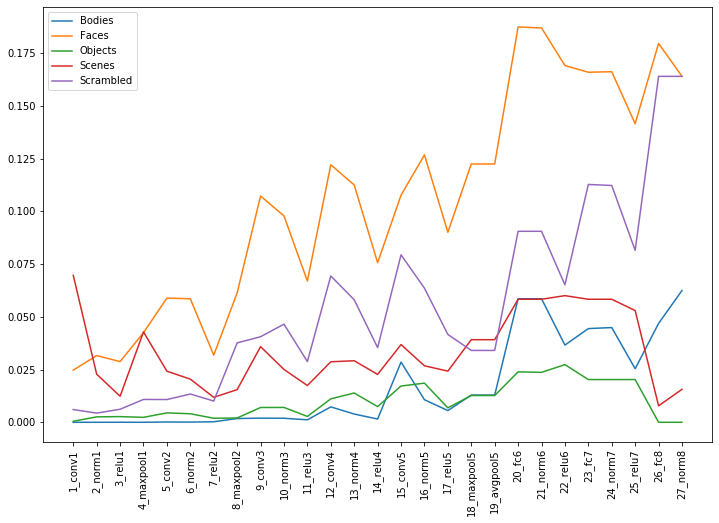

In [11]:
## run deepnet floc experiment, returning a dict with each layer's pref dict
pref_dicts = dict()

with tqdm(total=100,desc='Conducting deepnet floc experiments') as pbar:
    for layer in layers_to_load:
        
        print(layer)
        time.sleep(0.1) 
        
        Y = utils.load_batched_activations(activation_loaddir, layer, batch_size)
        
        pref_dicts[layer] = floc_selectivity(Y, categ_idx, FDR_p)
        
        pbar.update(100/len(layers_to_load))

        
if draw_plots is True:
    domain_props = []
    for i in range(len(layers_to_load)):
        domain_props.append(pref_dicts[layers_to_load[i]]['domain_props'])
    domain_props = np.vstack(domain_props)

    plt.figure(figsize=(12,8))
    plt.plot(domain_props);
    plt.legend(floc_domains)
    plt.xticks(np.arange(len(layers_to_load)),np.array(layers_to_load),rotation=90);

In [12]:
## save preference dict for a given locset/model/param combination
save_str = 'layer_pref_dicts_FDR_p_' + str(FDR_p).replace('.','-') + save_as
save_fn = join(prefdict_savedir,save_str)

# saving
if exists(save_fn) and overwrite is False:
    print('skipping, file %s already exists' % save_str)
else:
    if save_as == '.npy':
        np.save(save_fn, pref_dicts)
    elif save_as == '.mat':
        sio.savemat(save_fn, {'pref_dicts': pref_dicts})
    else:
        raise ValueError('no file type specified')

In [13]:
print(pref_dicts[layer]['domain_counts'])

[8, 21, 0, 2, 21]


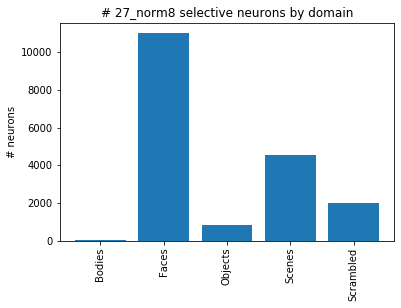

In [14]:
## plots
# selective neurons by domain
plt.figure()
plt.bar(np.arange(len(floc_domains)),pref_dicts['5_conv2']['domain_counts'])
plt.xticks(np.arange(len(floc_domains)),floc_domains,rotation=90);
plt.ylabel('# neurons')
plt.title('# %s selective neurons by domain' % layer);

(27, 5)


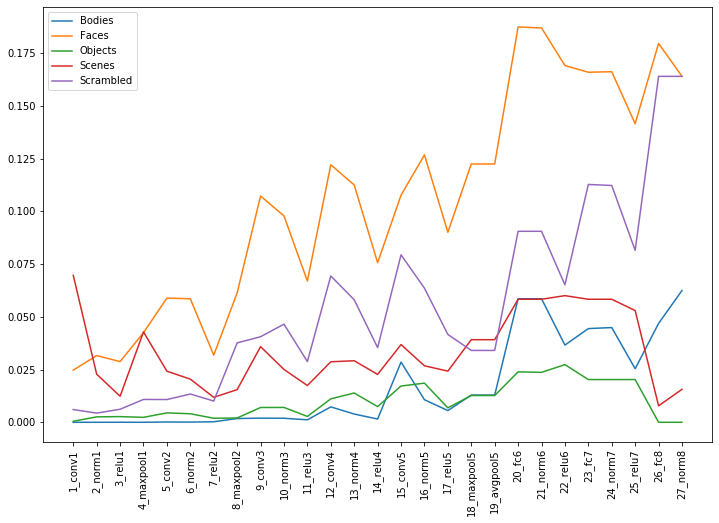

In [15]:
domain_props = []
for i in range(len(layers_to_load)):
    domain_props.append(pref_dicts[layers_to_load[i]]['domain_props'])
domain_props = np.vstack(domain_props)
print(domain_props.shape)

plt.figure(figsize=(12,8))
plt.plot(domain_props);
plt.legend(floc_domains)
plt.xticks(np.arange(len(layers_to_load)),np.array(layers_to_load),rotation=90);

In [20]:
activation_loaddir = '/home/jacobpri/git/RotspaceIT/data/d02_modeling/activations/cornet-z-object/experimental/mc8-lummatched/dim112/'

layer_list = ['9_conv3']




(16, 6, 28)
['FFA' 'OFA' 'FBA' 'EBA' 'LO' 'PPA' 'TOS' 'MT' 'VentralOTC' 'LateralOTC'
 'OPC' 'EarlyV2' 'VentralOTCRemoved' 'LateralOTCRemoved' 'OPCRemoved'
 'EarlyV2Removed']


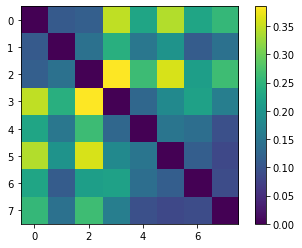

In [21]:
fmri_dir = join(home_dir,'data','d03_processing','Cohen2017')
brain_data = np.load(join(fmri_dir,'fmri_roi_rsa_subcube.npy'))
roi_list = np.load(join(fmri_dir,'roi_list.npy'))
print(brain_data.shape)
print(roi_list)

FFA_rdv = rsa.rsm2rdm(np.nanmean(np.squeeze(brain_data[5]),axis=0))

rsa.plot_matrix(rsa.v2m(FFA_rdv))

In [22]:
maps = []

for layer in layer_list:
    
    print(layer)
    Y = utils.load_batched_activations(activation_loaddir, [layer], 240, reshape_to_2D = False)
    #print(Y.shape)

    cohen_order = np.array([1,3,2,5,7,8,6,4])-1
    Y_categ = rsa.collapse_categs_4D(Y, np.repeat(np.arange(8),30))[cohen_order]
    #print(Y_categ.shape)

    Y = Y_categ
    dim = Y.shape
    #print(dim)
    map_dim = (Y.shape[2], Y.shape[3])
    a = np.zeros((8,8))
    map_depth = len(pdist(a,'correlation'))
    corr_map = np.empty(map_dim)
    corr_map[:] = np.nan

    dn_rdvs = np.zeros((map_dim[0],map_dim[1],map_depth))
    #print(dn_rdvs.shape)

    for i in range(map_dim[0]):
        for j in range(map_dim[1]):
            data = np.squeeze(Y[:,:,i,j])
            data_rdv = rsa.rdv(data)
            corr_map[i,j] = rsa.rdvcorr(FFA_rdv, data_rdv)

    maps.append(corr_map)

9_conv3


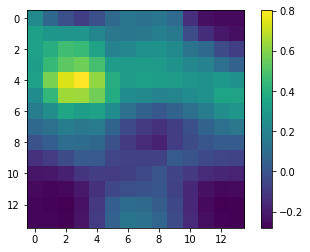

In [23]:
rsa.plot_matrix(corr_map)

IndexError: list index out of range

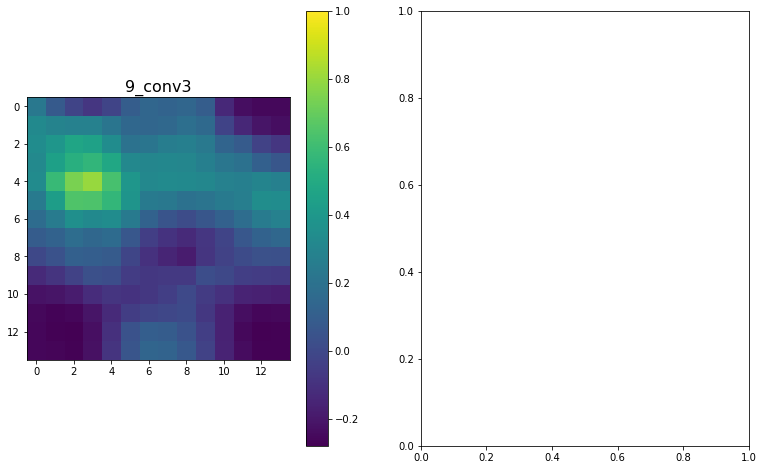

In [24]:
plt.figure(figsize=(20,8))
c = 1
for i in range(3):
    plt.subplot(1,3,c)
    rsa.plot_matrix(maps[c-1],vmin=0,vmax=1,tl=layer_list[c-1],fontsize=16)
    c+=1

In [ ]:
maps_ = maps